# Vectorizer + NaiveBayes Tuning

🎯 The goal of this challenge is to create a Pipeline combining a Vectorizer + a NaiveBayes algorithm and to fine-tune the pipeline.

✍️ Let's reuse the previous dataset with $2000$ reviews classified either as "positive" or "negative".

In [1]:
import pandas as pd

data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/10-Natural-Language-Processing/movie_reviews.csv")
data.head()

,target,reviews
0,neg,"plot : two teen couples go to a church party ,..."
1,neg,the happy bastard's quick movie review \ndamn ...
2,neg,it is movies like these that make a jaded movi...
3,neg,""" quest for camelot "" is warner bros . ' firs..."
4,neg,synopsis : a mentally unstable man undergoing ...


In [2]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data["target_encoded"] =  le.fit_transform(data.target)

In [3]:
data.head()

,target,reviews,target_encoded
0,neg,"plot : two teen couples go to a church party ,...",0
1,neg,the happy bastard's quick movie review \ndamn ...,0
2,neg,it is movies like these that make a jaded movi...,0
3,neg,""" quest for camelot "" is warner bros . ' firs...",0
4,neg,synopsis : a mentally unstable man undergoing ...,0


## Preprocessing

❓ **Question (Cleaning)** ❓

Clean your texts

In [4]:
import string

from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))

def preprocessing(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    sentence = ''.join(char for char in sentence if char not in string.punctuation)
    sentence = sentence.strip()
    tokens = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)


In [5]:
data['clean_reviews'] = data['reviews'].apply(preprocessing)
data.head()

,target,reviews,target_encoded,clean_reviews
0,neg,"plot : two teen couples go to a church party ,...",0,plot two teen couple go church party drink dri...
1,neg,the happy bastard's quick movie review \ndamn ...,0,happy bastard quick movie review damn yk bug g...
2,neg,it is movies like these that make a jaded movi...,0,movie like make jaded movie viewer thankful in...
3,neg,""" quest for camelot "" is warner bros . ' firs...",0,quest camelot warner bros first featurelength ...
4,neg,synopsis : a mentally unstable man undergoing ...,0,synopsis mentally unstable man undergoing psyc...


## Tuning

❓ **Question (Pipelining a Vectorizer and a NaiveBayes Model)** ❓

* Create a Pipeline that chains a vectorizer of your choice with a NaiveBayes model
* Optimize it
* What is your best estimator ?

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config; set_config("diagram")

set_config(display="diagram")

#X = data['clean_reviews'] CUANDO ESTAS HACIENDO MULTIPLES SCORING
#y = data['target_encoded']

# Create Pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('naive_bayes', MultinomialNB())
])
pipeline.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('naive_bayes', MultinomialNB())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'naive_bayes': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'naive_bayes__alpha': 1.0,
 'naive_bayes__class_prior': None,
 'naive_bayes__fit_prior': True,
 'naive_b

No necesitas hacer el CV si no te lo piden, pero para fines de visualizacion de mejora del score, seria ideal aplicarlo.

from sklearn.model_selection import cross_validate
cv_results = cross_validate(pipeline, X, y, cv = 5, scoring = ["recall"])
average_recall = cv_results["test_recall"].mean()
average_recall

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score UNICAMENTE SI QUEREMOS HACER VARIOS SCORES

Set parameters to search
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_df': [0.75, 1.0],
    'vectorizer__min_df': [1, 5],
    'naive_bayes__alpha': [0.1, 1.0]
}

scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

Perform grid search on pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X, y)

results_df = pd.DataFrame(grid_search.cv_results_)
results_df

In [70]:
# Set parameters to search
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_df': [0.75, 1.0],
    'vectorizer__min_df': [1, 5],
    'naive_bayes__alpha': [0.1, 1.0]
}

# Perform grid search on pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

In [71]:
X = data['clean_reviews']
y = data['target_encoded']
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('naive_bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'naive_bayes__alpha': [0.1, 1.0],
                         'vectorizer__max_df': [0.75, 1.0],
                         'vectorizer__min_df': [1, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='recall')

In [72]:
grid_search.best_params_

{'naive_bayes__alpha': 1.0,
 'vectorizer__max_df': 0.75,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 2)}

In [73]:
grid_search.best_score_

0.873

In [74]:
grid_search.best_estimator_

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.75, ngram_range=(1, 2))),
                ('naive_bayes', MultinomialNB())])

#### Podemos demostrar con una matriz de confusion (por el recall), para evaluar el desempeño. Asi podemos ver los VP VN FP FN, si existe este desbalance entre clases podriamos verlo claramente con esta matriz.

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [76]:
best_model = grid_search.best_estimator_

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['clean_reviews'], data['target_encoded'], test_size=0.2, random_state=42)

In [78]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.75, ngram_range=(1, 2))),
                ('naive_bayes', MultinomialNB())])

In [79]:
y_pred = best_model.predict(X_test)

In [80]:
cm = confusion_matrix(y_test, y_pred)

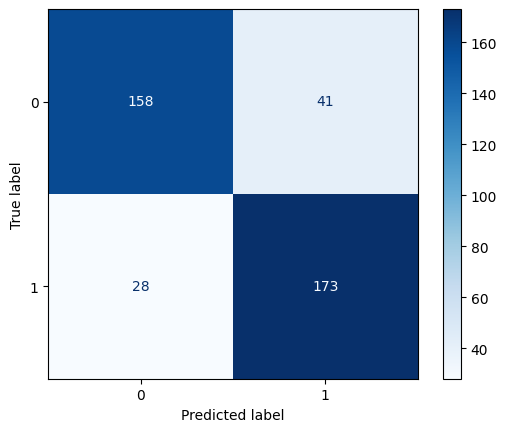

In [81]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')

In [ ]:
#### Estamos buscando que ()() parametros tomar de binomios, etc para poder saber hasta cual elegir. NO ME QUEDO CLARO 

In [82]:
import matplotlib.pyplot as plt

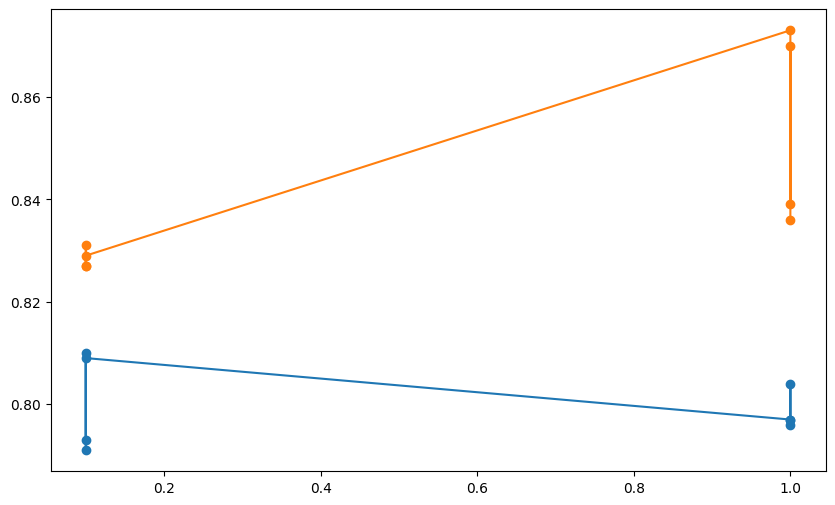

In [83]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[[
    'param_vectorizer__ngram_range',
    'param_vectorizer__max_df',
    'param_vectorizer__min_df',
    'param_naive_bayes__alpha',
    'mean_test_score'
]]

plt.figure(figsize=(10, 6))
for ngram in results_df['param_vectorizer__ngram_range'].unique():
    subset = results_df[results_df['param_vectorizer__ngram_range'] == ngram]
    plt.plot(subset['param_naive_bayes__alpha'], subset['mean_test_score'], marker='o')

🏁 Congratulations! You've managed to chain a Vectorizer and a NLP model and fine-tuned it!

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!